In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

from feature_engine.encoding import MeanEncoder
from feature_engine.discretisation import DecisionTreeDiscretiser
from feature_engine.transformation import BoxCoxTransformer

plt.style.use("dark_background")

# Load Dataset

In [2]:
df = pd.read_csv("Automobile.csv")
df.head()

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,usa
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,usa
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,usa
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,usa
4,ford torino,17.0,8,302.0,140.0,3449,10.5,70,usa


# Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          398 non-null    object 
 1   mpg           398 non-null    float64
 2   cylinders     398 non-null    int64  
 3   displacement  398 non-null    float64
 4   horsepower    392 non-null    float64
 5   weight        398 non-null    int64  
 6   acceleration  398 non-null    float64
 7   model_year    398 non-null    int64  
 8   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [4]:
df.isnull().sum()

name            0
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [5]:
df[df.isnull().any(axis = 1)]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,ford pinto,25.0,4,98.0,NaN,2046,19.0,71,usa
126,ford maverick,21.0,6,200.0,NaN,2875,17.0,74,usa
330,renault lecar deluxe,40.9,4,85.0,NaN,1835,17.3,80,europe
336,ford mustang cobra,23.6,4,140.0,NaN,2905,14.3,80,usa
354,renault 18i,34.5,4,100.0,NaN,2320,15.8,81,europe
374,amc concord dl,23.0,4,151.0,NaN,3035,20.5,82,usa


In [6]:
df["name"].nunique()

305

In [7]:
df[df["name"]== "ford pinto"]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,ford pinto,25.0,4,98.0,NaN,2046,19.0,71,usa
112,ford pinto,19.0,4,122.0,85.0,2310,18.5,73,usa
130,ford pinto,26.0,4,122.0,80.0,2451,16.5,74,usa
168,ford pinto,23.0,4,140.0,83.0,2639,17.0,75,usa
174,ford pinto,18.0,6,171.0,97.0,2984,14.5,75,usa
206,ford pinto,26.5,4,140.0,72.0,2565,13.6,76,usa


In [8]:
df[df["name"]== "ford maverick"]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
17,ford maverick,21.0,6,200.0,85.0,2587,16.0,70,usa
100,ford maverick,18.0,6,250.0,88.0,3021,16.5,73,usa
126,ford maverick,21.0,6,200.0,NaN,2875,17.0,74,usa
155,ford maverick,15.0,6,250.0,72.0,3158,19.5,75,usa
193,ford maverick,24.0,6,200.0,81.0,3012,17.6,76,usa


In [9]:
df[df["name"]== "renault lecar deluxe"]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
330,renault lecar deluxe,40.9,4,85.0,NaN,1835,17.3,80,europe


In [10]:
df[df["name"]== "ford mustang cobra"]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
336,ford mustang cobra,23.6,4,140.0,NaN,2905,14.3,80,usa


In [11]:
df[df["name"] == "renault 18i"]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
354,renault 18i,34.5,4,100.0,NaN,2320,15.8,81,europe


In [12]:
df[df["name"] == "amc concord dl"]

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
374,amc concord dl,23.0,4,151.0,NaN,3035,20.5,82,usa


In [13]:
missing_cars = {
    "ford pinto": [32, 75], 
    "ford maverick": [126, 75], 
    "renault lecar deluxe": [330, 53.5], 
    "ford mustang cobra": [336, 135],
    "renault 18i": [354, 81],
    "amc concord dl": [374, 82]
    }

for car, values in missing_cars.items():
    index = values[0]
    car_horsepower = values[1]
    
    df.at[index, "horsepower"] = car_horsepower
    print(f"The {car} was filled with: {car_horsepower}.")

The ford pinto was filled with: 75.
The ford maverick was filled with: 75.
The renault lecar deluxe was filled with: 53.5.
The ford mustang cobra was filled with: 135.
The renault 18i was filled with: 81.
The amc concord dl was filled with: 82.


In [14]:
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    
    return percent_nan

In [15]:
percent_missing(df)

Series([], dtype: float64)

In [16]:
df.to_csv("Cleaned_mpg_dataset.csv", index = False)

In [17]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.154523,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.405786,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [18]:
df["origin"].value_counts()

origin
usa       249
japan      79
europe     70
Name: count, dtype: int64

In [19]:
df["name"].nunique()

305

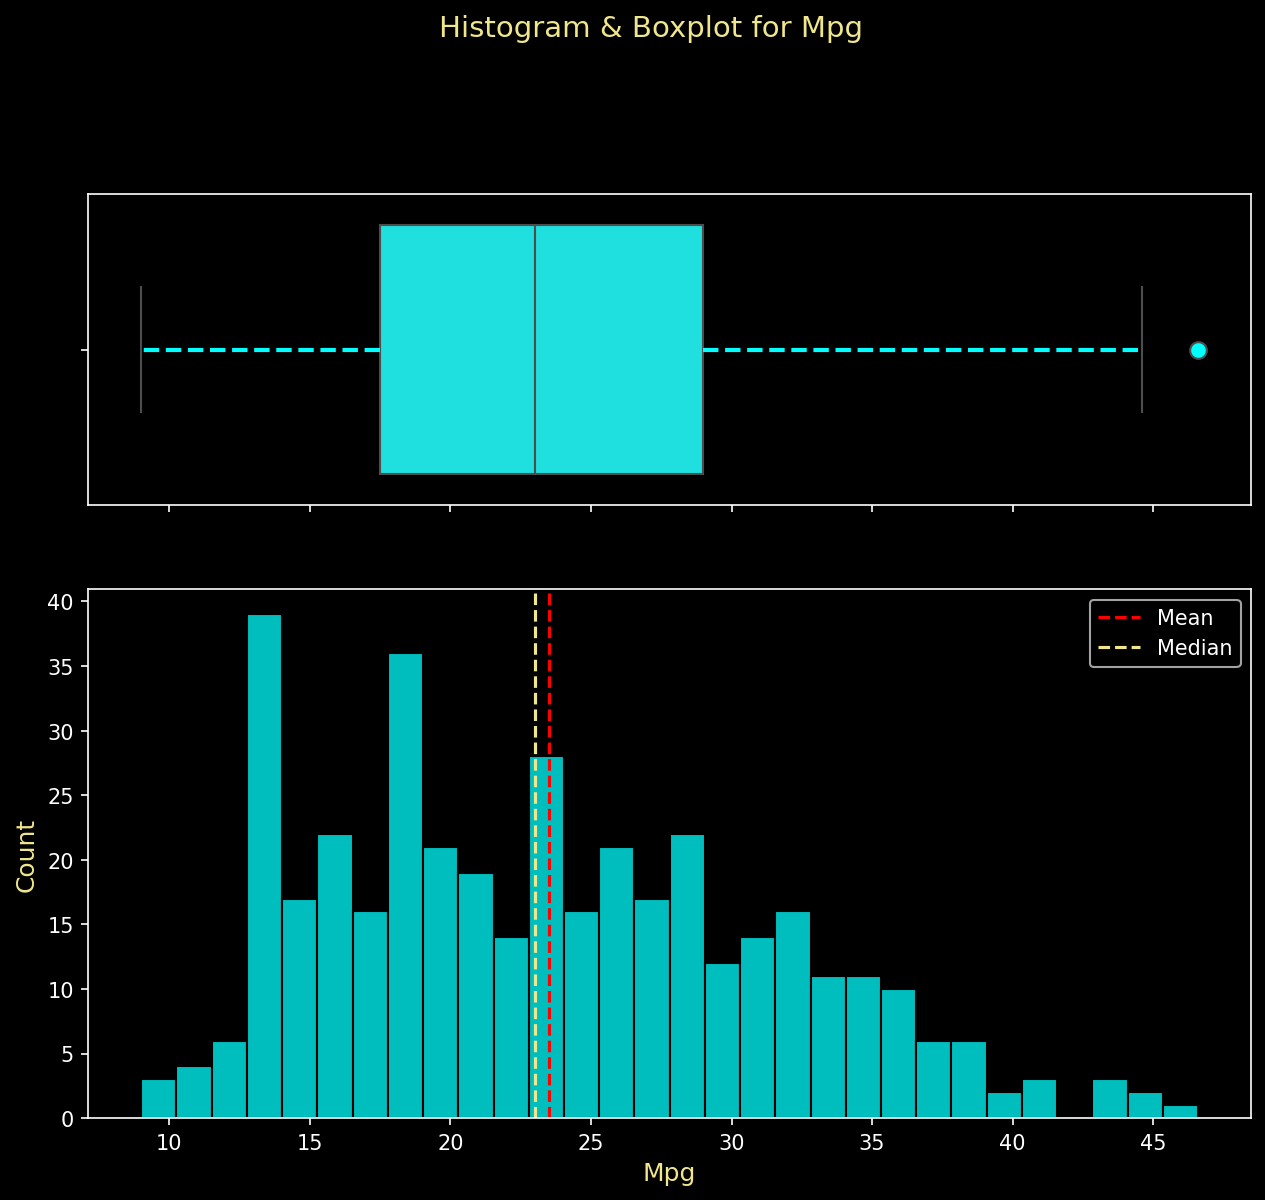

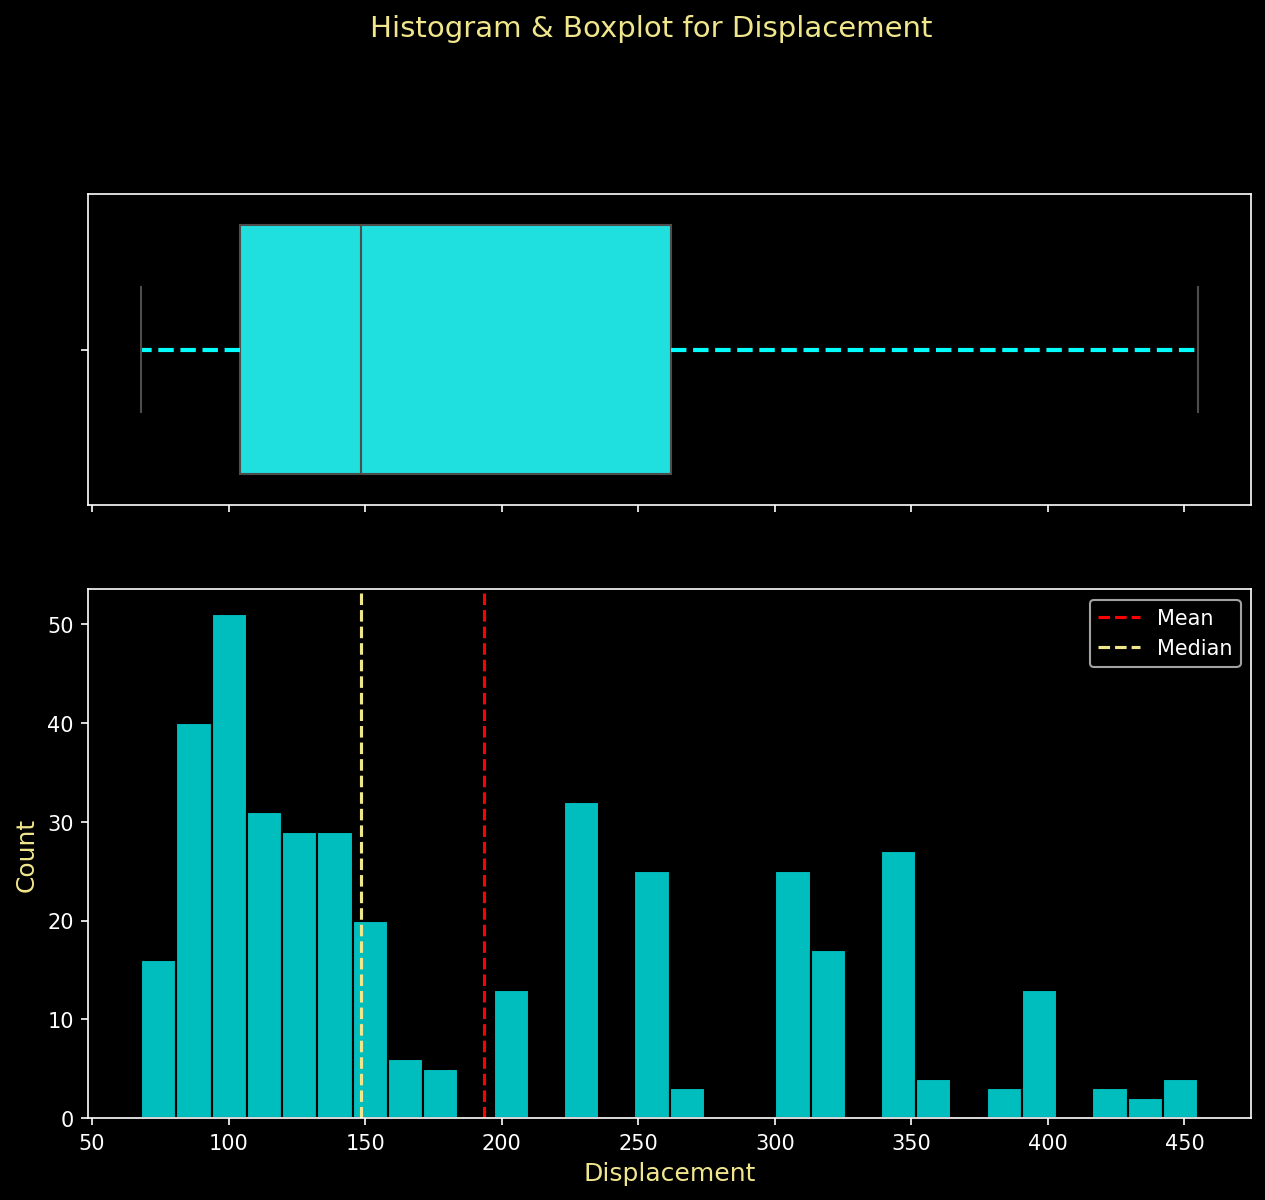

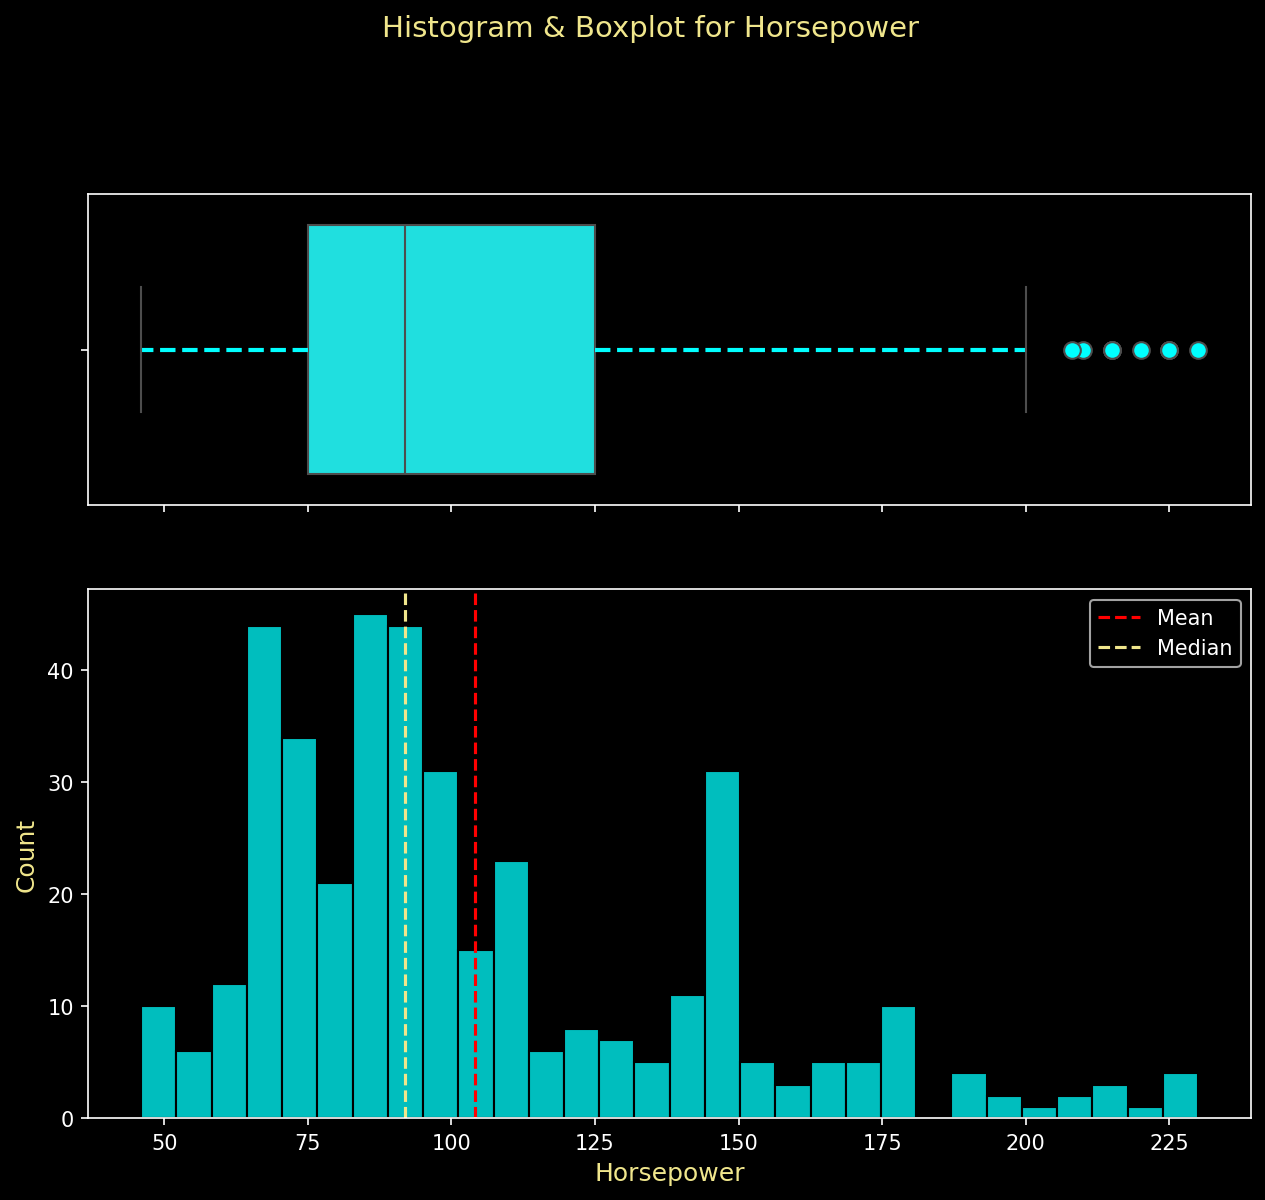

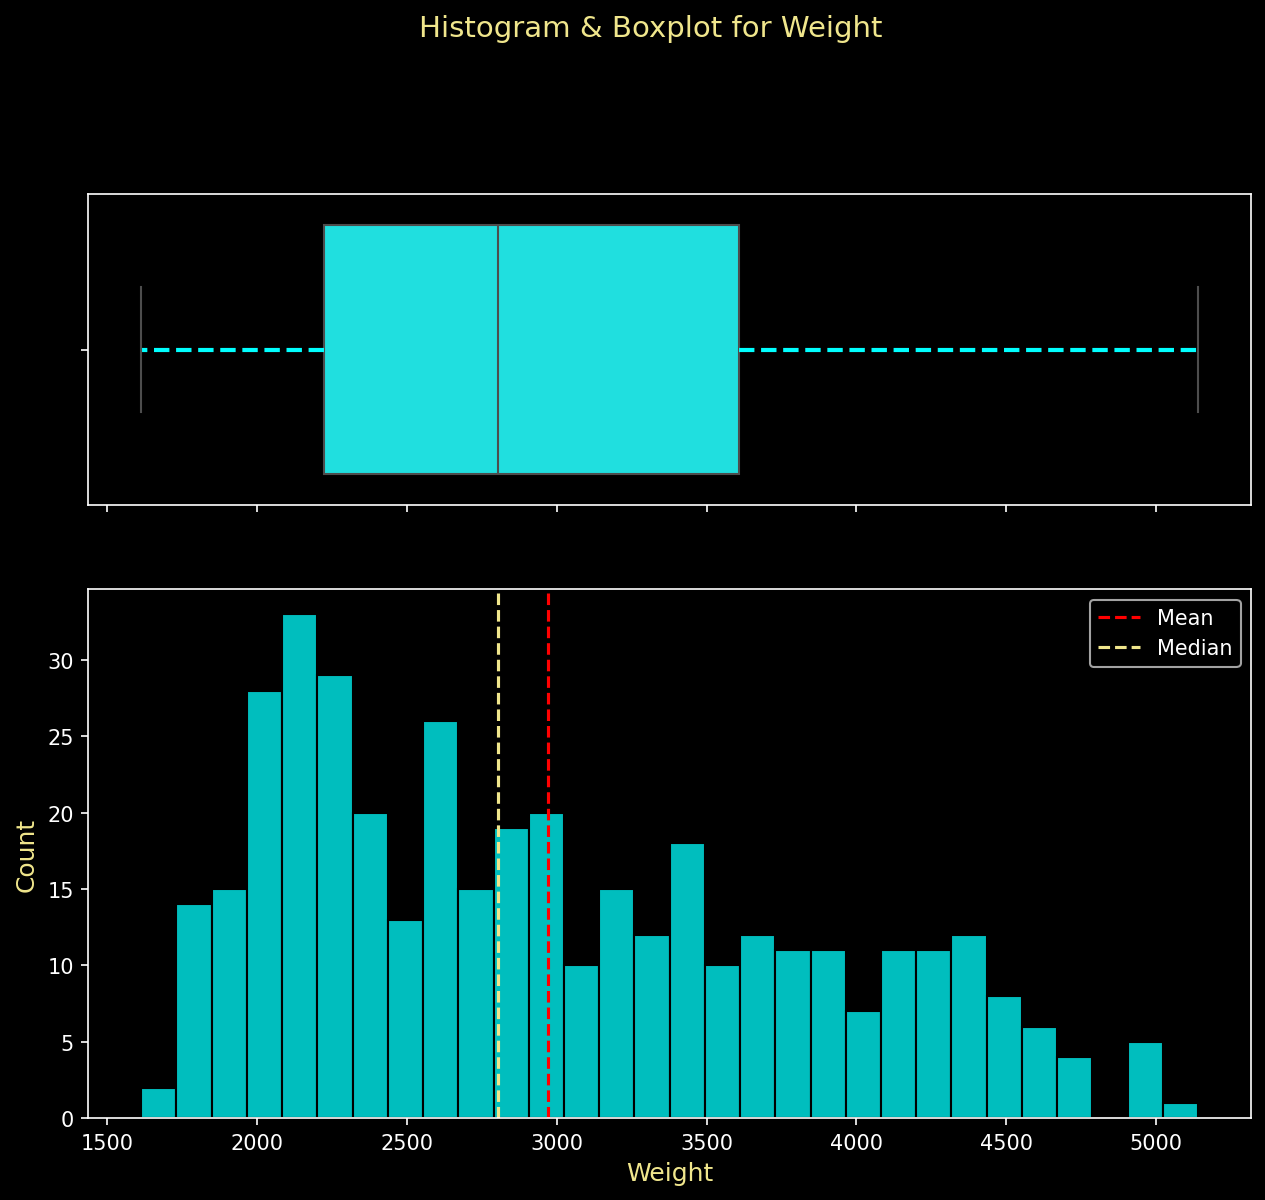

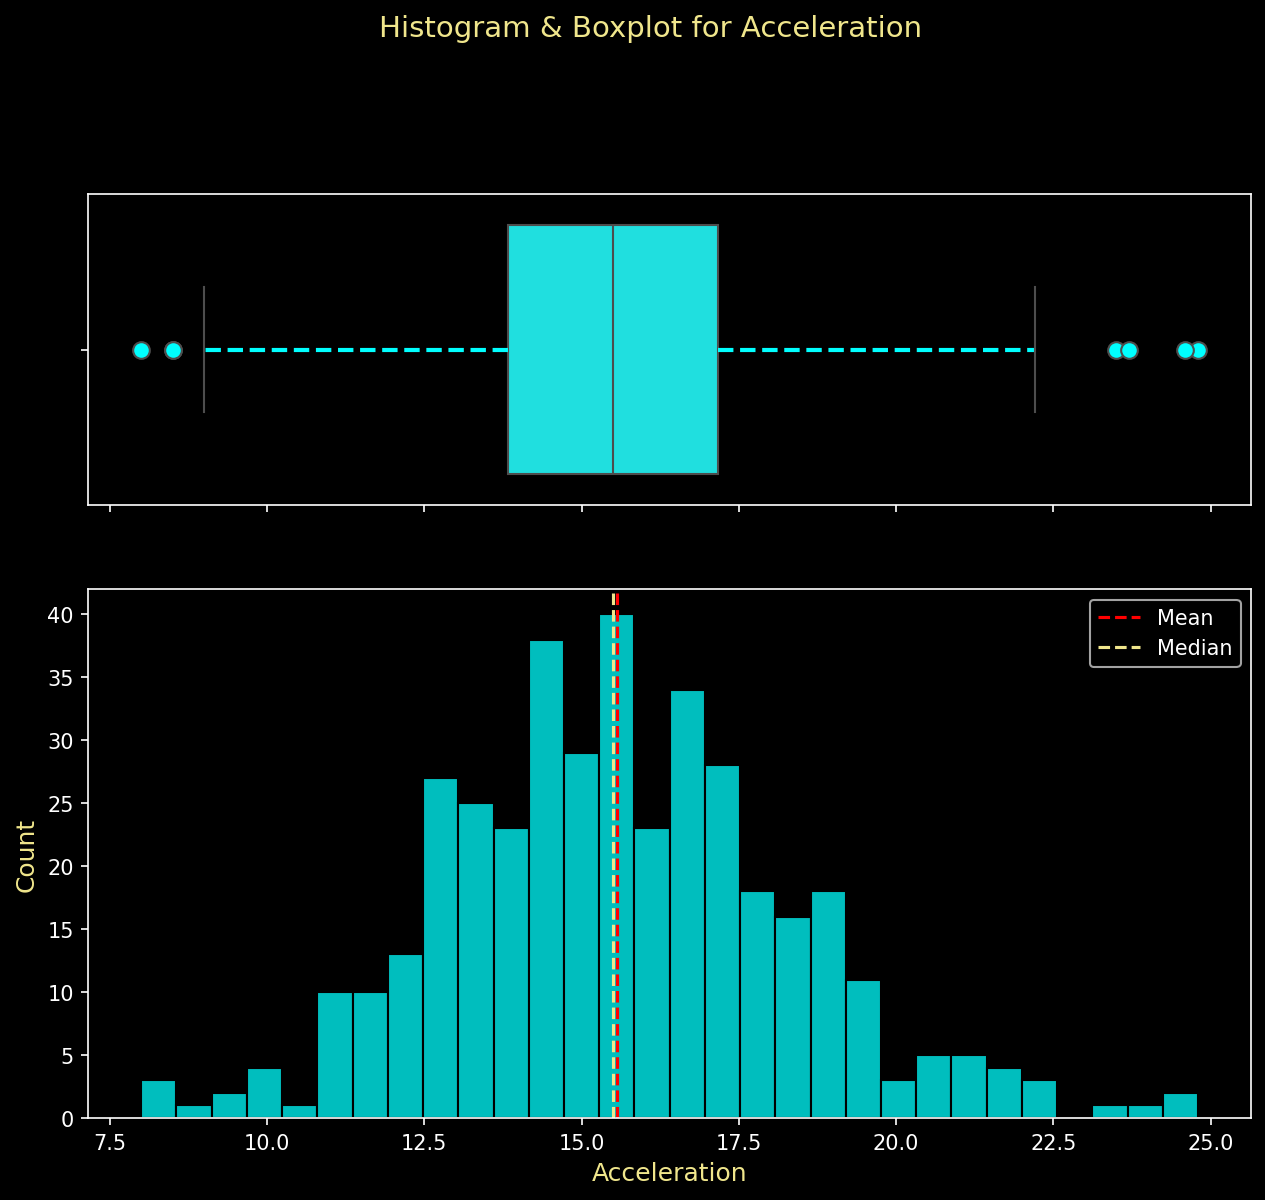

In [20]:
for var in df.drop(["name", "origin", "model_year", "cylinders"], axis = 1).columns:
    
    f, (ax_box, ax_hist) = plt.subplots(
        2, 
        sharex= True, 
        gridspec_kw={"height_ratios": (0.50, 0.85)},
        figsize = (10, 8),
        dpi = 150 
    )
    
    box_plot = sns.boxplot(
        x = df[var],
        color = "aqua",
        ax = ax_box,
        whiskerprops = {
            "color" : "aqua",
            "linewidth": 2,
            "linestyle" : "--"
        },
        flierprops = {
            "markerfacecolor" : "aqua",
            "markersize": 8
        }
        )
    
    histogram = sns.histplot(
        data = df,
        x = var,
        bins = 30,
        color = "aqua",
        edgecolor = "black",
        ax = ax_hist
    )
    
    box_plot.set(xlabel = "")
    
    histogram.figure.suptitle(
        f"Histogram & Boxplot for {var.capitalize()}",
        fontsize = 14,
        color = "khaki",
        y = 1.03
        )
    
    plt.axvline(
        x = df[var].mean(),
        linestyle = "--",
        color = "red",
        label = "Mean"
    )
    
    plt.axvline(
        x = df[var].median(),
        linestyle = "--",
        color = "khaki",
        label = "Median"
    )
    
    ax_hist.set_xlabel(f"{var.capitalize()}", color = "khaki", fontsize = 12)
    ax_hist.set_ylabel(f"Count", color = "khaki", fontsize = 12)
    
    plt.legend();

<blockquote>
Acceleration appears normally distributed with a few outliers.
<br>Weight, Horsepower, and Displacement are skewed to the right. </blockquote>

## Feature: Cylinders

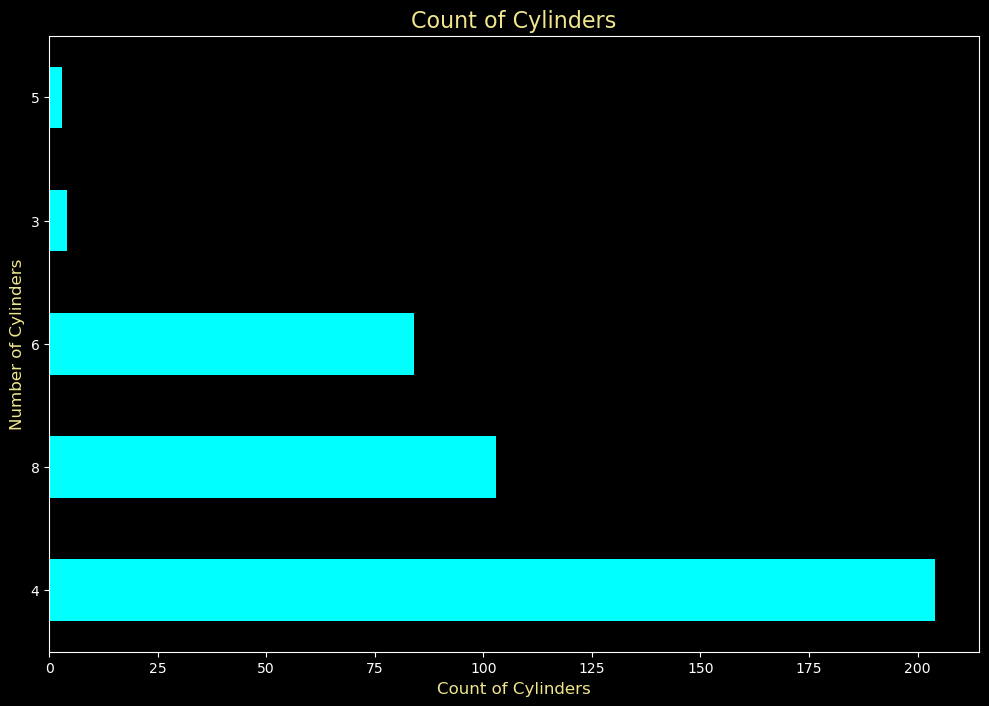

In [21]:
plt.figure(figsize = (12, 8))
df["cylinders"].value_counts().plot(kind = "barh", color = "aqua")
plt.xlabel("Count of Cylinders", color = "khaki", fontsize =  12)
plt.ylabel("Number of Cylinders", color = "khaki", fontsize = 12)
plt.title("Count of Cylinders", color = "khaki", fontsize = 16);

<blockquote> Cars with 4 cylinders is the most common. <br />While, 5 and 3 were the least common.

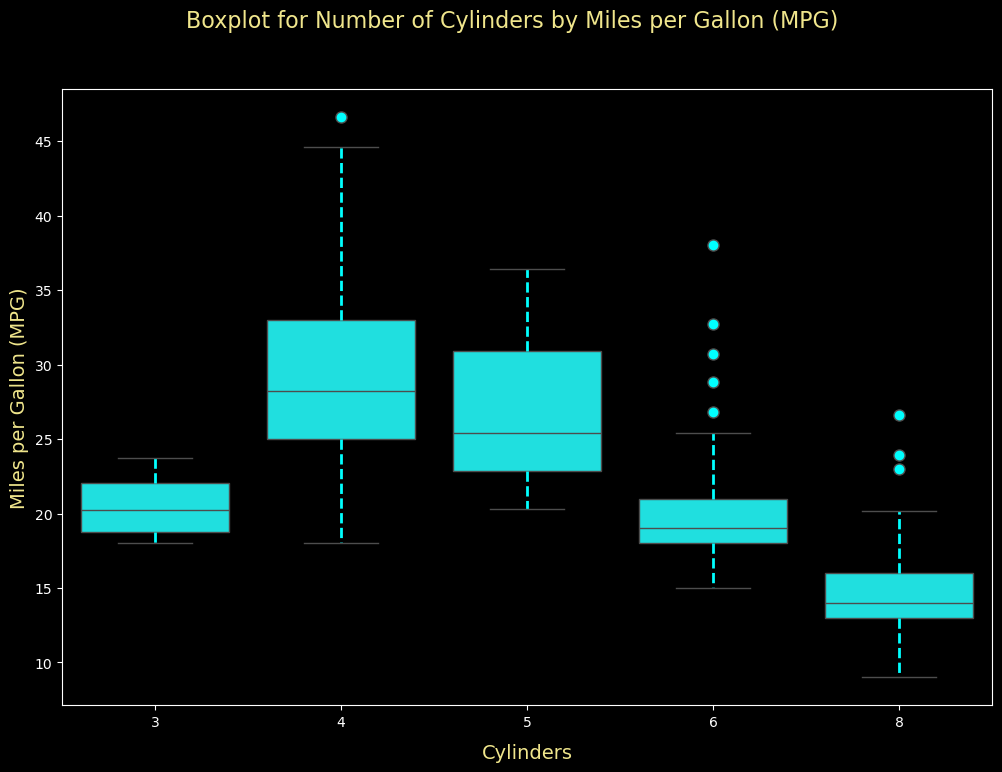

In [22]:
plt.figure(figsize = (12, 8), dpi = 100)
boxplot = sns.boxplot(
    data = df,
    x = "cylinders",
    y = "mpg",
    color = "aqua",
    whiskerprops = { # Adjusts the whisker properties
        "color" : "aqua",
        "linewidth" : 2,
        "linestyle": "--"
    },
    flierprops = { # Adjusts the outlier properties
        "markerfacecolor": "aqua",
        "markersize" : 8,
    }
)
boxplot.set_xlabel(
    xlabel = "Cylinders", 
    color = "khaki",
    fontsize = 14,
    labelpad = 10
    )

boxplot.set_ylabel(
    ylabel = "Miles per Gallon (MPG)",
    color = "khaki",
    fontsize = 14
)

boxplot.figure.suptitle(
    "Boxplot for Number of Cylinders by Miles per Gallon (MPG)", 
    fontsize = 16, color = "khaki"
    );

<blockquote>There are outliers present in cars with 3, 4 and 8 cylinders.</blockquote>

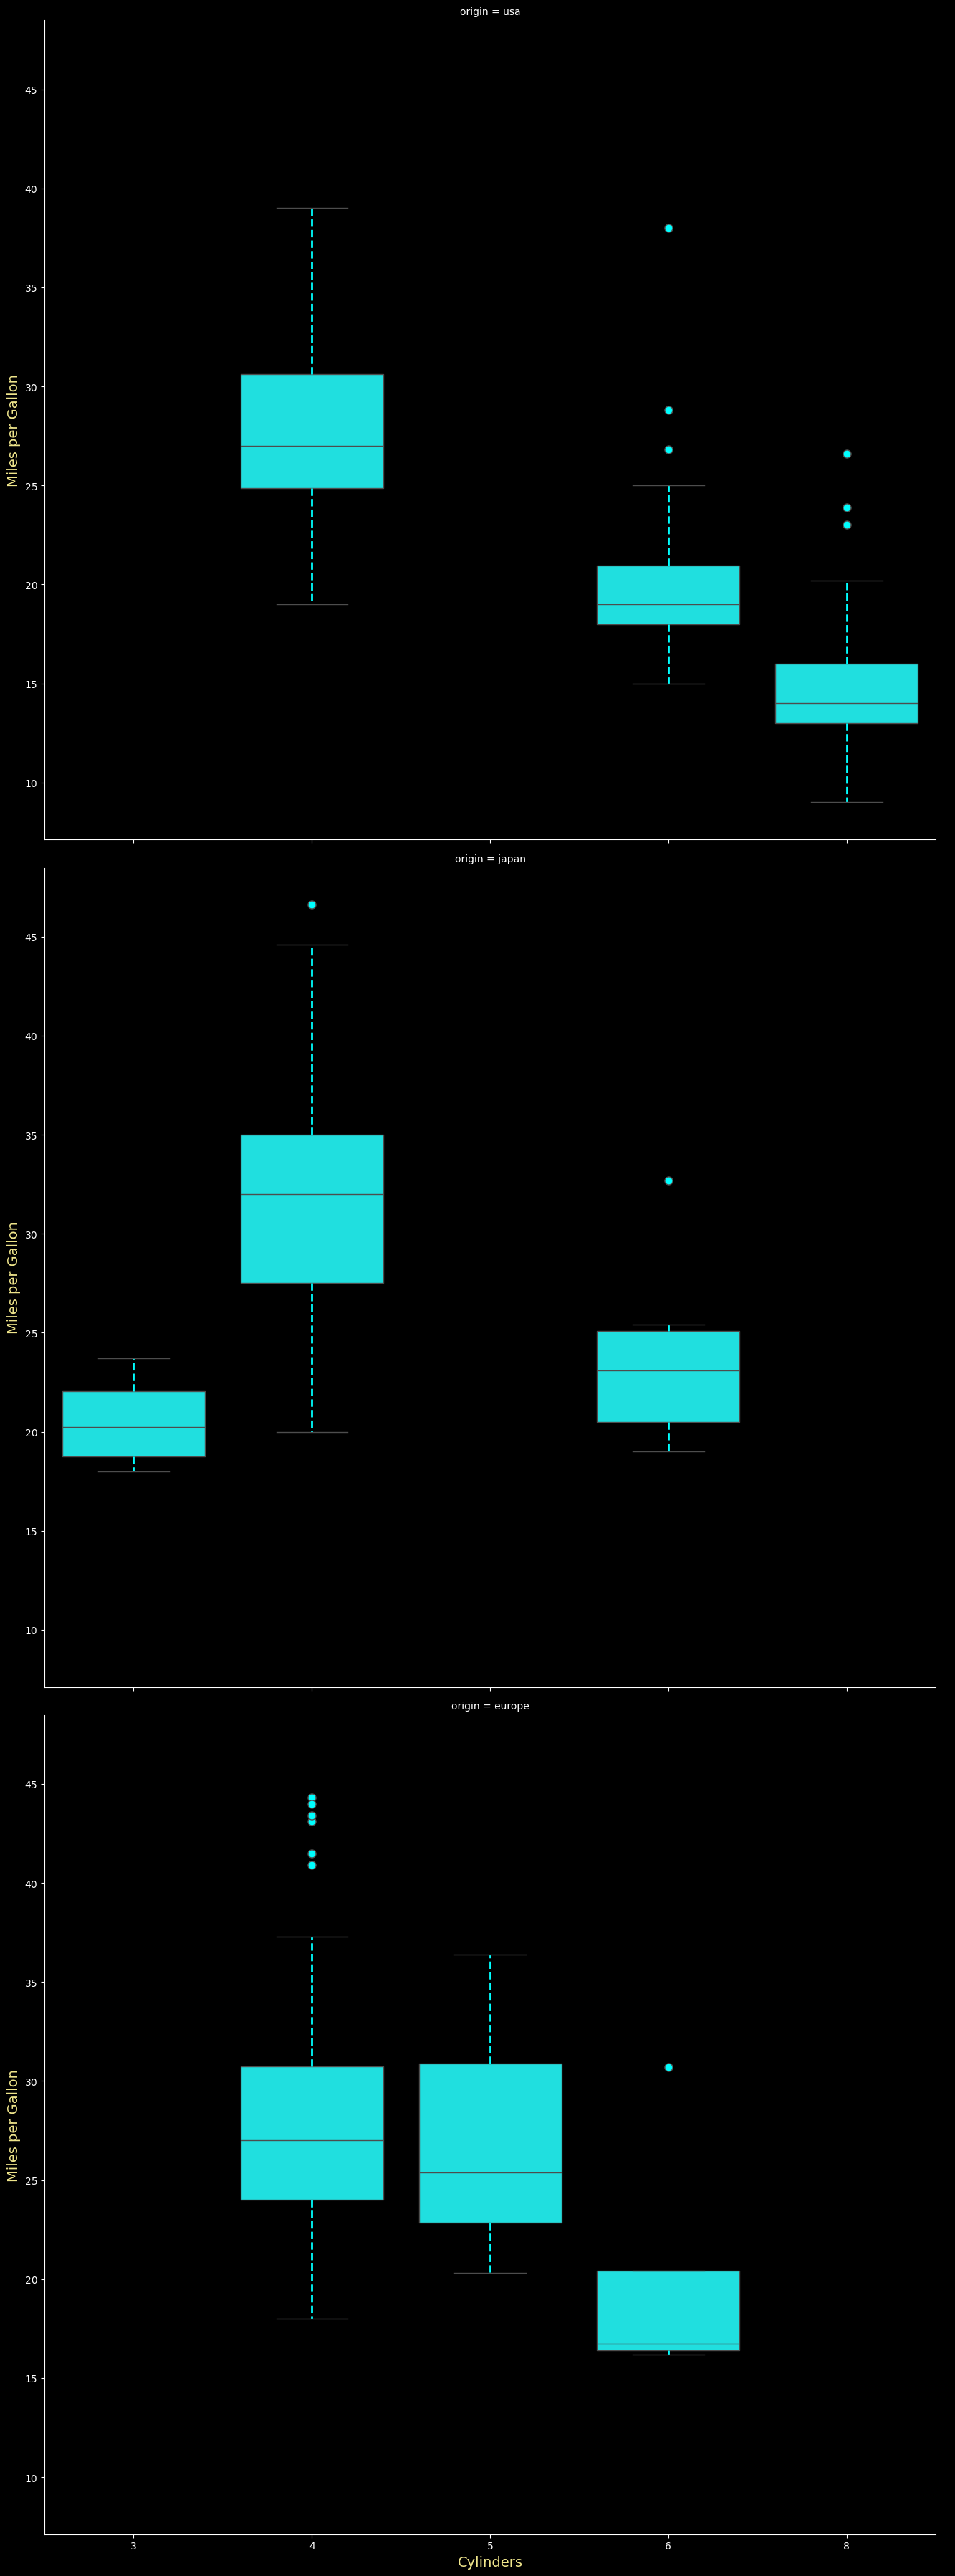

In [23]:

catplot = sns.catplot(
    data = df,
    x = "cylinders",
    y = "mpg",
    kind = "box",
    row = "origin",
    color = "aqua",
    whiskerprops = {
        "color": "aqua",
        "linestyle" : "--",
        "linewidth": 2 
    },
    flierprops = {
        "markerfacecolor" : "aqua",
        "markersize": 8
    },
    height= 12,
    aspect = 1.1
)
catplot.set_xlabels("Cylinders", fontsize = 14, color = "khaki")
catplot.set_ylabels("Miles per Gallon", fontsize = 14, color = "khaki");

<blockquote>European have cars with engines containing: 4, 5, and 6 cylinders. 
<br />Outliers in cars with 4 and 6 cylinders.
<br />Japanese cars have engines containg: 3, 4 and 6 Cylinders. 
<br />Outliers in cars with 4 and 6 cylinders.
<br />American cars have engines containing: 4, 6 and 8 cylinders.<br />Outliers in cars with 6 and 8 cylinders.

### Scatterplots with Histograms for: 
- Displacement
- Horsepower
- Weight
- Acceleration

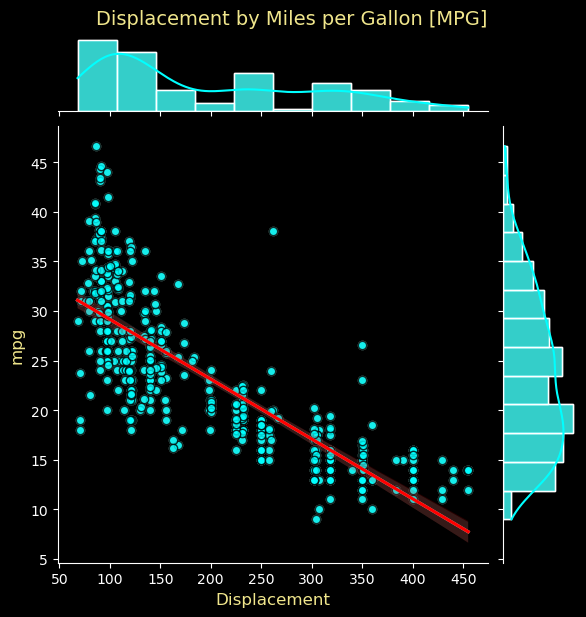

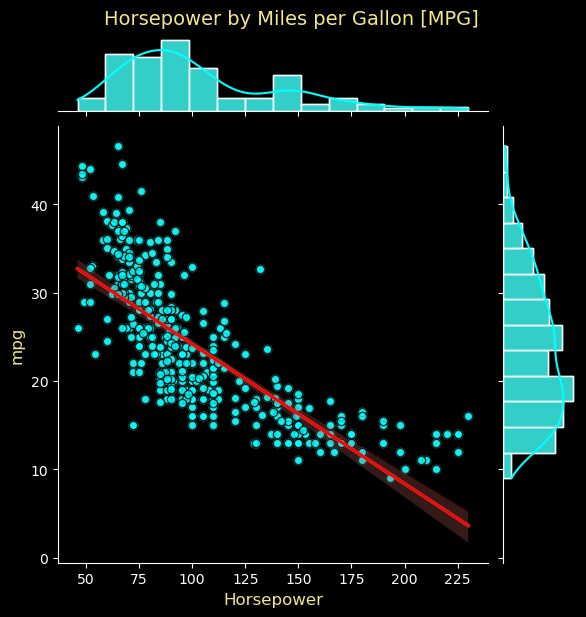

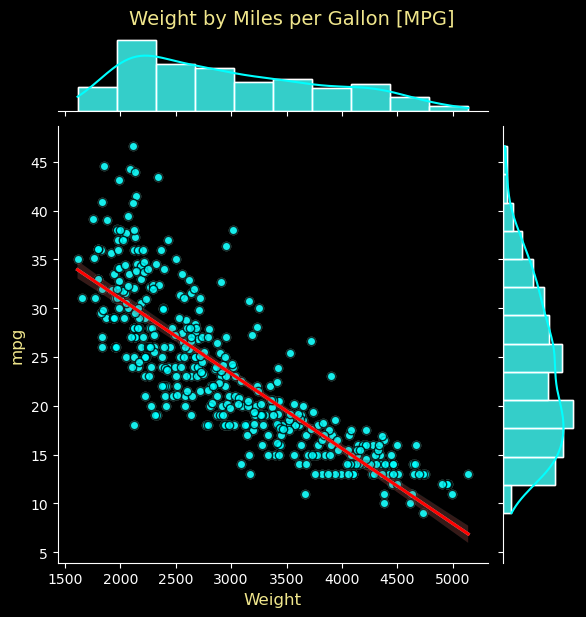

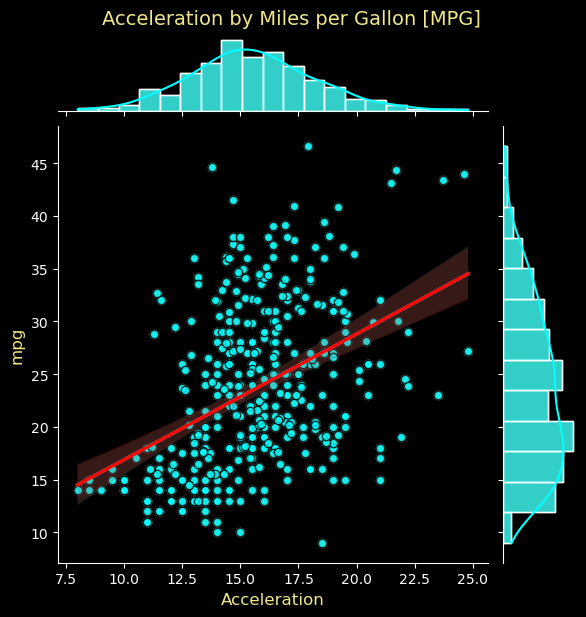

In [24]:
for var in df.drop(["name","origin","model_year", "mpg", "cylinders"], axis = 1).columns:    
    g = scatter = sns.JointGrid(
        data = df,
        x = var,
        y = "mpg"
    )
    g = g.plot(sns.regplot, sns.histplot)
    g.plot_marginals(sns.histplot, color = "aqua", kde = True)
    
    sns.regplot(
        data = df,
        x = var,
        y = "mpg",
        ax = g.ax_joint,
        scatter_kws={"color": "aqua", "edgecolor": "black"},
        line_kws = {"color": "red"}
    )
    g.set_axis_labels(
        f"{var.capitalize()}",
        "mpg",
        color = "khaki",
        fontsize = 12
    )
    
    g.figure.suptitle(
        f"{var.capitalize()} by Miles per Gallon [MPG]",
        y = 1.02,
        fontsize = 14,
        color = "khaki"
    )

<blockquote>The car acceleration does not have high correlation with Miles per Gallon.</blockquote>

## Feature: Origin

In [25]:
df["origin"].value_counts()

origin
usa       249
japan      79
europe     70
Name: count, dtype: int64

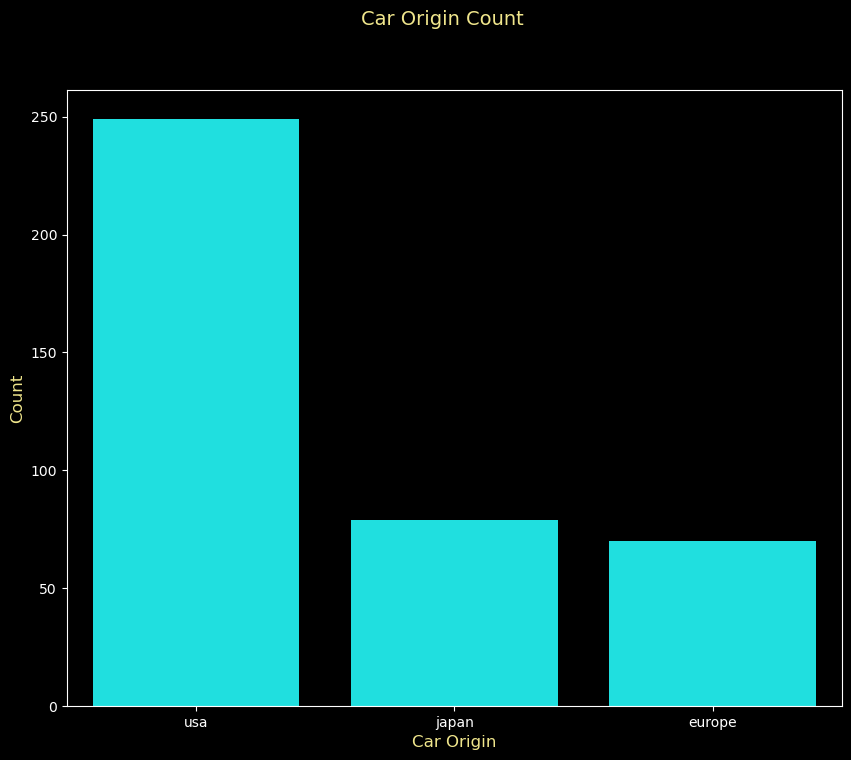

In [26]:
plt.figure(figsize = (10, 8))
countplot = sns.countplot(
    data = df,
    x = "origin",
    color = "aqua",
)

countplot.set_xlabel("Car Origin", fontsize = 12, color= "khaki")
countplot.set_ylabel("Count", fontsize = 12, color = "khaki")
countplot.figure.suptitle(t ="Car Origin Count", fontsize = 14, color = "khaki");

<blockquote>Cars of European origin have outliers with 4 and 6 cylinders. <br>
Cars of American origin have outliers with 6 and 8 cylinders.</blockquote>

## Feature: Model Year

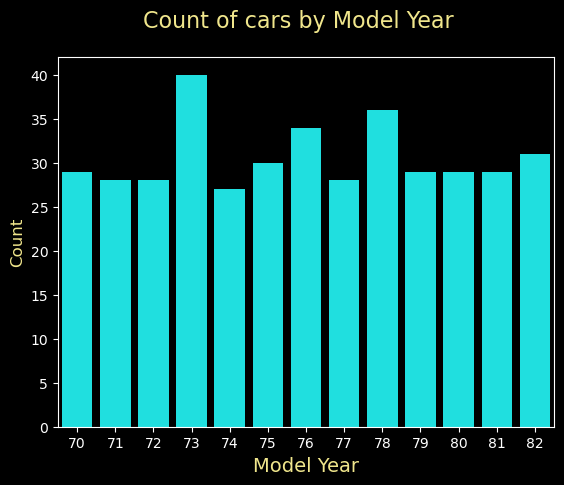

In [27]:
countplot = sns.countplot(
    data = df,
    x = "model_year",
    color = "aqua"
)

countplot.set_xlabel(
    "Model Year", 
    color ="khaki", 
    fontsize = 14
    )

countplot.set_ylabel(
    "Count", 
    color = "khaki", 
    fontsize = 12
    )

countplot.figure.suptitle(
    "Count of cars by Model Year", 
    color = "khaki", 
    fontsize = 16
    );

## Analyzing Multicollinearity

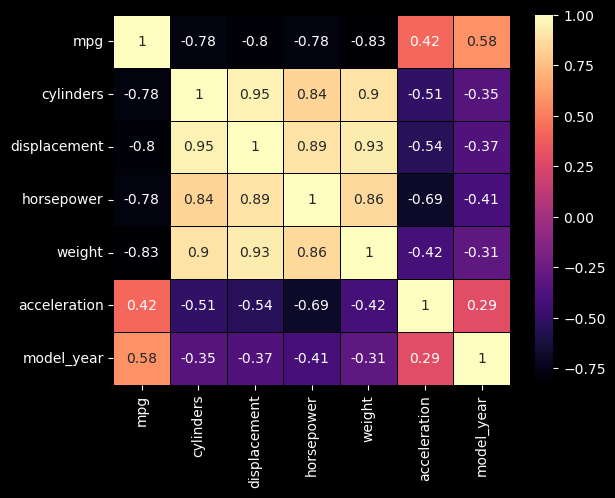

In [28]:
corr = df.corr(numeric_only= True)
sns.heatmap(corr, 
            annot = True,
            linewidths = 0.7,
            cmap = "magma",
            linecolor = "black"
            );

<blockquote>The dataset has the presence of multicollinearity. <br />
Cylinders, Displacement, Horsepower and Weight are highly correlated among themselves. </blockquote>

# Train Test Split

In [29]:
X = df.drop(["mpg", "name", "displacement", "cylinders"], axis = 1)
y = df["mpg"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.3,
    random_state= 42
)

## Feature Engineering

In [31]:
X_train["model_year"] = X_train["model_year"].astype(str)
X_test["model_year"] = X_test["model_year"].astype(str)

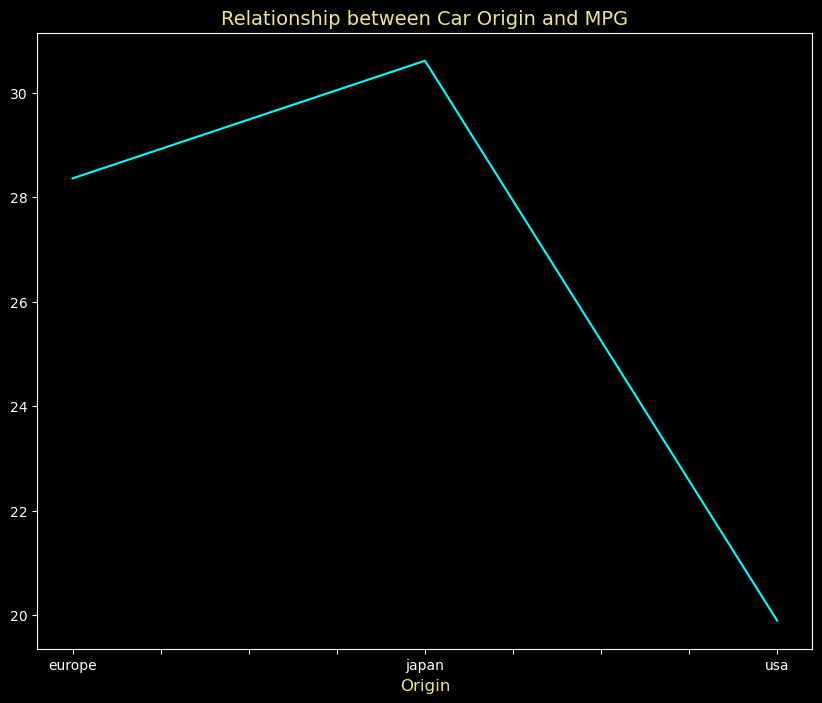

In [32]:
fig = plt.figure(figsize= (10, 8))
fig = y_train.groupby(X_train["origin"]).mean().plot(color = "aqua")
plt.xlabel("Origin", color = "Khaki", fontsize = 12)
plt.title("Relationship between Car Origin and MPG",color = "khaki", fontsize = 14 );

In [33]:
treeDisc = DecisionTreeDiscretiser(
    cv = 10, 
    scoring = "neg_mean_squared_error",
    variables = ["horsepower", "acceleration"],
    regression = True,
    param_grid = {
        "max_depth" : [1, 2, 3],
        "min_samples_leaf": [10, 4]
    }
)
treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        variables=['horsepower', 'acceleration'])

In [34]:
treeDisc.binner_dict_["horsepower"].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [35]:
treeDisc.scores_dict_["horsepower"]

-18.445130846311958

In [36]:
treeDisc.binner_dict_["acceleration"].best_params_

{'max_depth': 1, 'min_samples_leaf': 10}

In [37]:
treeDisc.scores_dict_["acceleration"]

-51.53473800300419

In [38]:
X_train = treeDisc.transform(X_train)
X_test = treeDisc.transform(X_test)

In [39]:
pipe = Pipeline([
    ("encoder", MeanEncoder(variables= ["origin", "model_year"])),
    ("bct_transformer", BoxCoxTransformer(variables= ["weight"])),
    ("poly", PolynomialFeatures(degree = 3, interaction_only = True)),
    ("scaler", StandardScaler()),
    ]
)

In [40]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('encoder', MeanEncoder(variables=['origin', 'model_year'])),
                ('bct_transformer', BoxCoxTransformer(variables=['weight'])),
                ('poly', PolynomialFeatures(degree=3, interaction_only=True)),
                ('scaler', StandardScaler())])

In [41]:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [42]:
X_train = pd.DataFrame(X_train, columns= pipe.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = pipe.get_feature_names_out())

## Feature Selection

In [43]:
sel = SelectFromModel(
    Lasso(alpha = 0.1, random_state= 42)
)

In [44]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.1, random_state=42))

In [45]:
selected_feat = X_train.columns[sel.get_support()]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel.estimator_.coef_ == 0)))

total features: 26
selected features: 5
features with coefficients shrank to zero: 21


In [46]:
print(list(selected_feat))

['weight', 'model_year', 'horsepower model_year', 'weight acceleration', 'model_year origin']


In [47]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [48]:
X_train = pd.DataFrame(X_train, columns= sel.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = sel.get_feature_names_out())

# Model Building

## Baseline Model

In [49]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean Miles per Gallon:", round(y_mean, 2))
print("Baseline MSE:", mean_squared_error(y_train, y_pred_baseline))

Mean Miles per Gallon: 23.45
Baseline MSE: 62.45097872780912


## Hyperparameter Tuning

In [50]:
elastic = ElasticNet()

In [51]:
param_grid = {
    "l1_ratio" : [0.1, 0.6, 0.8, 1],
    "alpha" : [0.1, 1, 10, 100, 1000],
    "max_iter": [10000000]
}

In [52]:
search  = GridSearchCV(
    elastic, 
    param_grid, 
    cv = 5,
    scoring = "neg_mean_squared_error",
    refit= True
)

In [53]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 10, 100, 1000],
                         'l1_ratio': [0.1, 0.6, 0.8, 1],
                         'max_iter': [10000000]},
             scoring='neg_mean_squared_error')

In [54]:
search.best_params_

{'alpha': 0.1, 'l1_ratio': 0.6, 'max_iter': 10000000}

In [55]:
results = pd.DataFrame(search.cv_results_)

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001500,0.000447,0.000801,0.000401,0.1,0.1,10000000,"{'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 10...",-5.149773,-7.640007,-12.406669,-5.519825,-7.377690,-7.618793,2.587820,3
1,0.001202,0.000751,0.001102,0.000202,0.1,0.6,10000000,"{'alpha': 0.1, 'l1_ratio': 0.6, 'max_iter': 10...",-5.238615,-7.692765,-12.262829,-5.520996,-7.275367,-7.598114,2.520093,1
2,0.001002,0.000003,0.001127,0.000247,0.1,0.8,10000000,"{'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 10...",-5.293312,-7.768773,-12.206959,-5.536014,-7.242493,-7.609510,2.488404,2
3,0.000903,0.000199,0.001001,0.000003,0.1,1,10000000,"{'alpha': 0.1, 'l1_ratio': 1, 'max_iter': 1000...",-5.370224,-7.912259,-12.151818,-5.558677,-7.219926,-7.642581,2.453196,4
4,0.001391,0.000809,0.000800,0.000400,1,0.1,10000000,"{'alpha': 1, 'l1_ratio': 0.1, 'max_iter': 1000...",-6.903020,-12.594536,-17.445429,-10.266070,-11.917230,-11.825257,3.430629,8


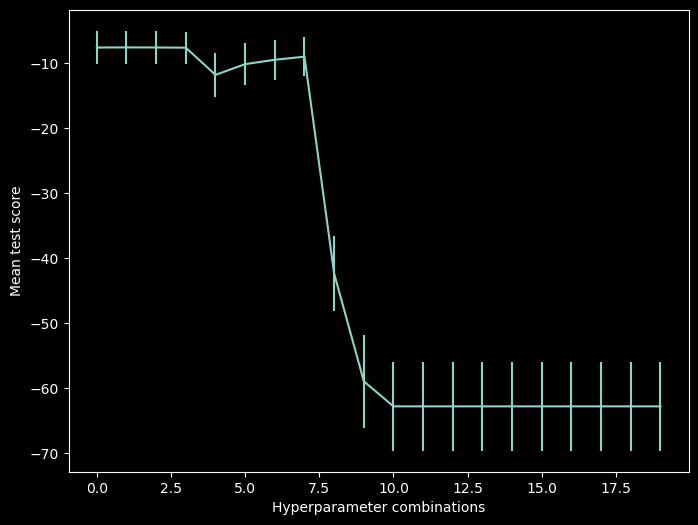

In [56]:
plt.figure(figsize = (8, 6))
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations');

## Model Evaluation

In [57]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

In [58]:
y_test_pred_baseline = [y_mean] * len(X_test)

print("Baseline Model Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_pred_baseline)))
print("Baseline Model Test set Root Mean Squared Error: ", mean_squared_error(y_test, y_test_pred_baseline))


print("The Training Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, X_train_preds)))
print("The Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, X_test_preds)))

print("The Training R-Squared: ", r2_score(y_train, X_train_preds))
print("The Test R-Squared: ", r2_score(y_test, X_test_preds))

Baseline Model Root Mean Squared Error:  7.902593164766178
Baseline Model Test set Root Mean Squared Error:  57.44194573262254
The Training Root Mean Squared Error:  2.6915121948993725
The Test Root Mean Squared Error:  2.491190216239248
The Training R-Squared:  0.8840012111440902
The Test R-Squared:  0.8918647637386493


## Residual Analysis

In [59]:
residuals = y_test - X_test_preds

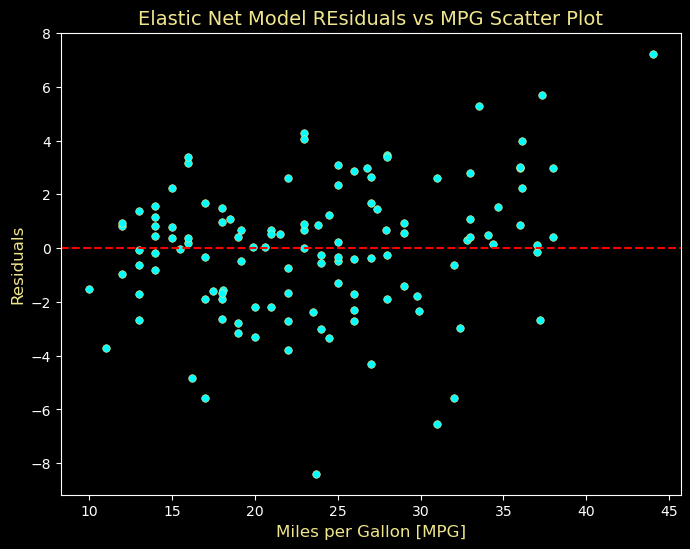

In [60]:
plt.figure(figsize = (8, 6))
scatter_plot = sns.scatterplot(
    x = y_test,
    y = residuals,
    color = "aqua",
    edgecolor = "khaki",
    s = 30
)

plt.axhline(
    y = 0,
    color = "red",
    ls = "--"
),
scatter_plot.set_xlabel(
    "Miles per Gallon [MPG]",
    fontsize = 12,
    color = "khaki"
)

scatter_plot.set_ylabel(
    "Residuals",
    fontsize = 12,
    color = "khaki"
)

scatter_plot.set_title(
    "Elastic Net Model REsiduals vs MPG Scatter Plot",
    fontsize = 14,
    color = "khaki"
);

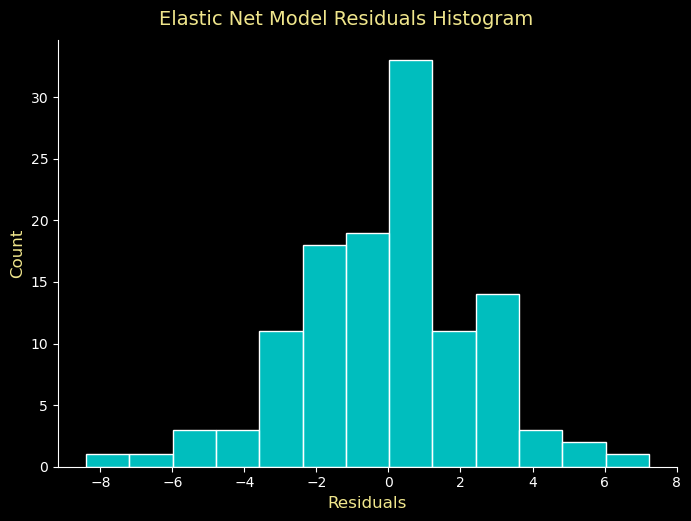

In [61]:
histogram_plot = sns.displot(
    x = residuals,
    color = "aqua",
    aspect = 1.4
)

histogram_plot.set_axis_labels(
    "Residuals",
    "Count",
    fontsize = 12,
    color = "khaki"
)

histogram_plot.figure.suptitle(
    "Elastic Net Model Residuals Histogram",
    y = 1.03,
    color = "khaki",
    fontsize = 14,
    );

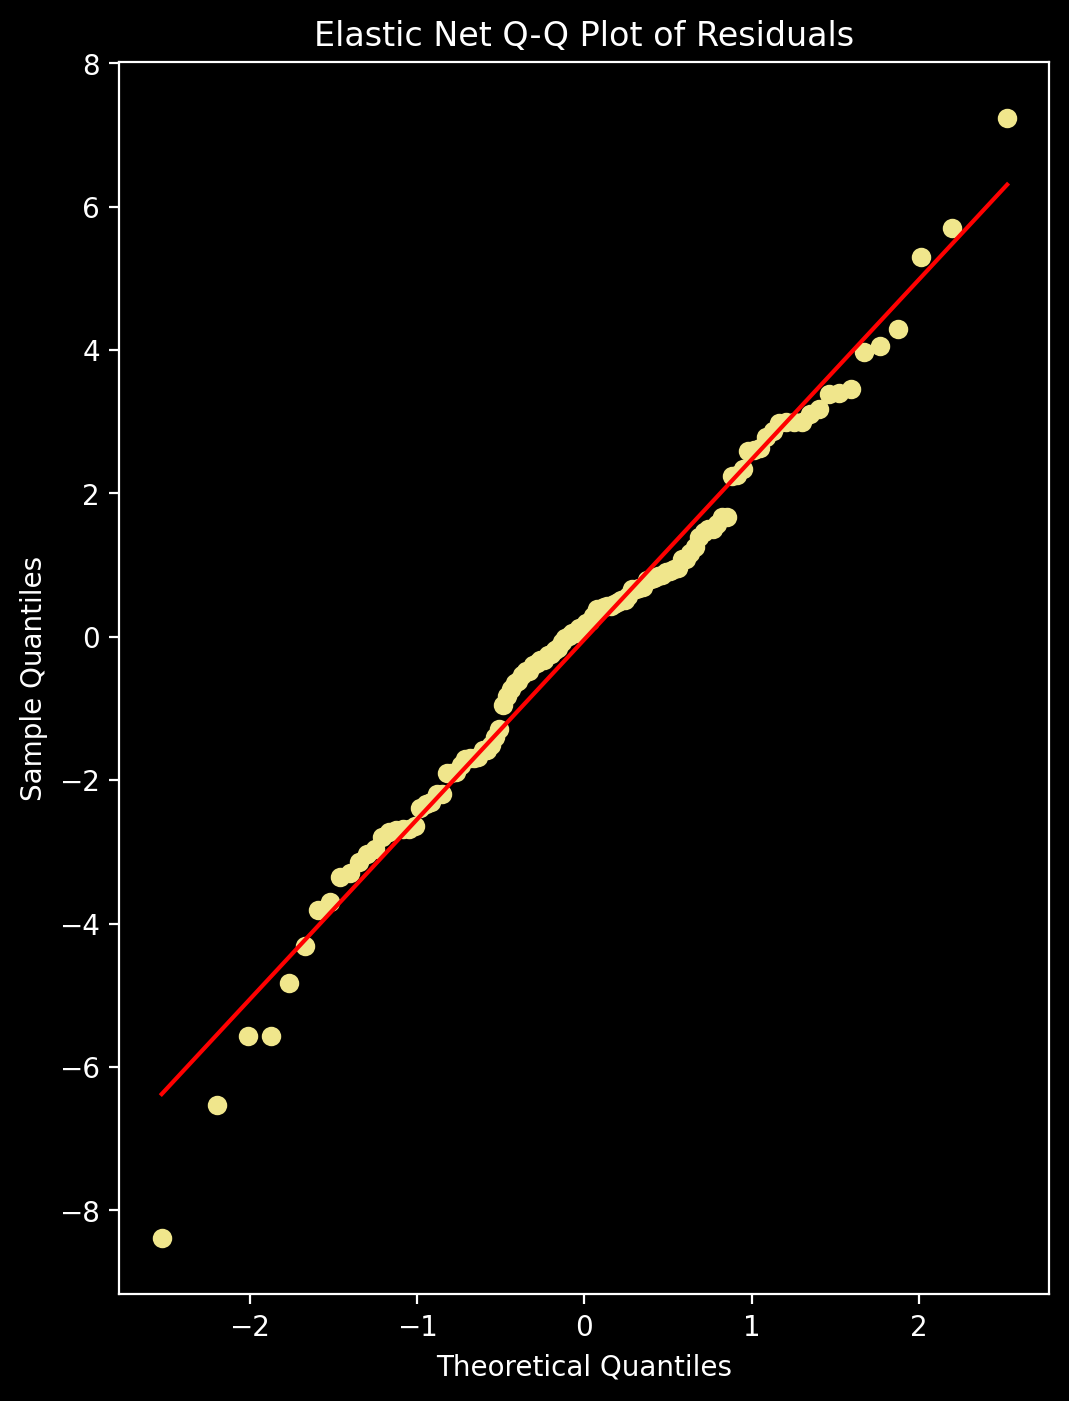

In [62]:
fig, ax = plt.subplots(figsize = (6, 8), dpi = 200)
st.probplot(residuals, plot = ax)

ax.get_lines()[0].set_color("khaki")
ax.get_lines()[1].set_color("red")

ax.set_title("Elastic Net Q-Q Plot of Residuals")
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles');

# Communication

In [63]:
final_tree_discretizer = DecisionTreeDiscretiser(
    cv = 10, 
    scoring = "neg_mean_squared_error",
    variables = ["horsepower", "acceleration"],
    regression = True,
    param_grid = {
        "max_depth" : [1, 2, 3],
        "min_samples_leaf": [10, 4]
    }
)

In [64]:
final_tree_discretizer.fit(X, y)
X = final_tree_discretizer.transform(X)

In [66]:
X["model_year"] = X["model_year"].astype(str)

In [67]:
final_pipe = Pipeline([
    ("encoder", MeanEncoder(variables= ["origin", "model_year"])),
    ("bct_transformer", BoxCoxTransformer(variables= ["weight"])),
    ("poly", PolynomialFeatures(degree = 3, interaction_only = True)),
    ("scaler", StandardScaler()),
    ]
)

final_pipe.fit(X, y)
X = final_pipe.transform(X)
X = pd.DataFrame(X, columns = final_pipe.get_feature_names_out())


In [68]:
final_selector = SelectFromModel(
    Lasso(alpha = 0.1, random_state= 42)
)

final_selector.fit(X, y)
X = final_selector.transform(X)
X = pd.DataFrame(X, columns = final_selector.get_feature_names_out())

In [69]:
final_model = ElasticNet(
    alpha= 0.1, 
    l1_ratio = 0.6, 
    max_iter = 10000000
    )

final_model.fit(X, y)

ElasticNet(alpha=0.1, l1_ratio=0.6, max_iter=10000000)

In [70]:
final_model.coef_

array([-3.39838275,  0.88068075,  1.53728151,  0.52694025,  0.69483788,
        1.05541108])

In [71]:
r = permutation_importance(
    final_model,
    X,
    y,
    n_repeats = 30,
    random_state = 42
)

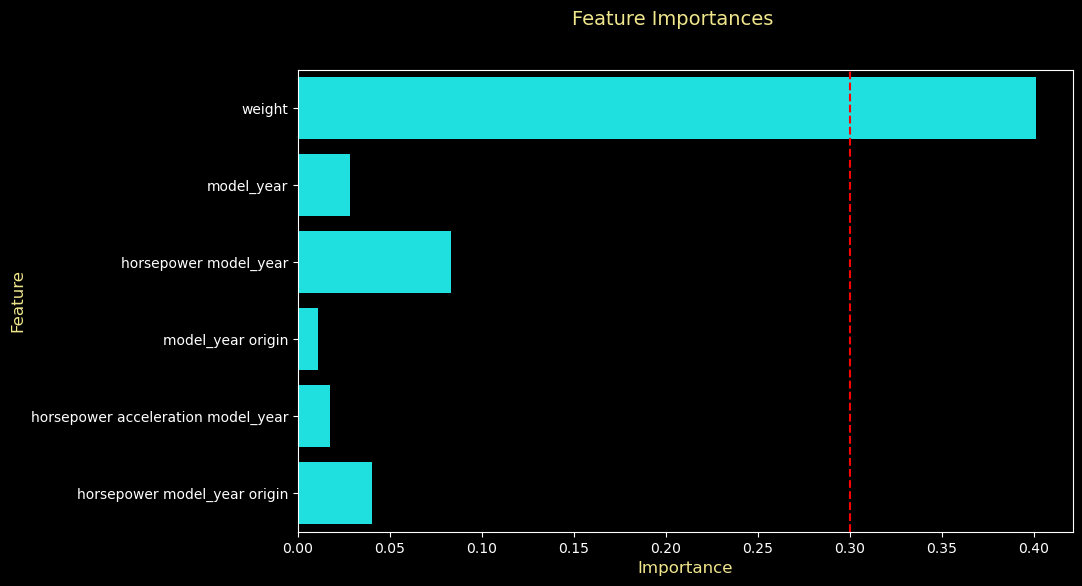

In [74]:
feature_names = list(X.columns)
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": r.importances_mean
})

plt.figure(figsize = (10, 6))
bar = sns.barplot(
    data = importance_df,
    x = "Importance",
    y = "Feature",
    color = "aqua"
)
plt.axvline(
    x = 0.3,
    color = "red",
    ls = "--"
)
bar.set_xlabel("Importance", fontsize = 12, color = "khaki")
bar.set_ylabel("Feature", fontsize = 12, color = "khaki")
bar.figure.suptitle("Feature Importances", fontsize = 14, color = "khaki");

<blockquote>The most important feature for predicting the miles per gallon is the weight of car followed by the horsepower with the model year.